In [93]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [100]:
pd.set_option('display.max_rows', 2000)

In [23]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """
    Utilise `sns.scatterplot` en appliquant d'abord une ACP si besoin
    pour réduire la dimension.
    """

    # Select columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    sp_kwargs = {}
    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        sp_kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        sp_kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **sp_kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.
    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

def kmeans_dataset(dataset, n_clusters_list, strategies, tries):
    '''Analyse kmeans with different parameters'''
    for n_clusters in n_clusters_list:
        for strategy in strategies:
            for rs in range(tries): # On utilisera `rs` pour fixer le random_state`
                inertia = KMeans(
                    n_clusters=n_clusters,
                    n_init=1,
                    random_state=rs,
                    init=strategy,).fit(dataset).inertia_
                yield rs, strategy, n_clusters, inertia

# Tuning k-means

## 1, Étude des K-means sur Iris

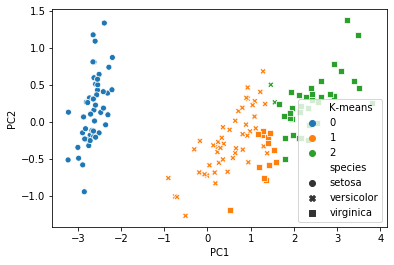

In [19]:
iris = sns.load_dataset('iris')
iris0 = iris.drop(columns=["species"])
cls = KMeans(n_clusters=3, init="random")
cls.fit(iris0)
labels = pd.Series(cls.labels_, name="K-means")
scatterplot_pca(data=iris0, hue=labels, style=iris.species)
plt.show()

In [24]:
gen = kmeans_dataset(iris0, [3, 5, 10], ["random", "k-means++"], 100)
df = pd.DataFrame(gen, columns=["seed", "init", "n_clusters", "inertia"])
df = df.astype({
    "seed": "int32",
    "n_clusters": "int32"
})

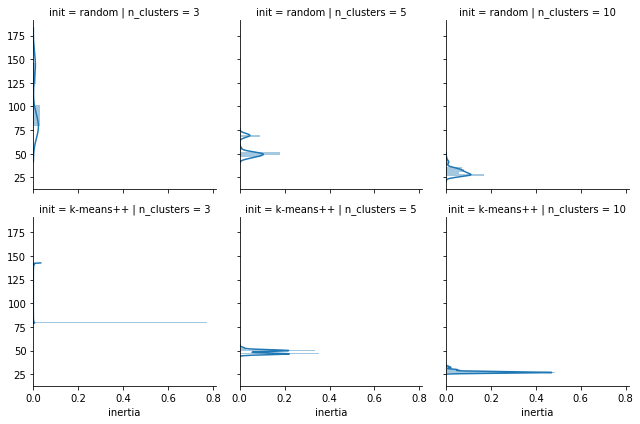

In [30]:
g = sns.FacetGrid(df, row="init", col="n_clusters")
g.map(sns.distplot, "inertia", vertical=True)
plt.show()

Tout d’abord, on observe que lorsque le nombre de groupements augmente, l’inertie intra-classe
diminue quelque soit la stratégie d’initialisation des centres.
En revanche l’algorithme semble de plus en plus instable lorsque le nombre de groupements aug-
mente. Cela se manifeste par une dispersion (relative) de la distribution des inerties.
Cette dispersion, qui peut donner des mauvaises classifications en terme d’inertie, est largement
réduite en utilisant une stratégie d’initialisation des centres plus performante (k-means++).

inertia: 145.7649378722375


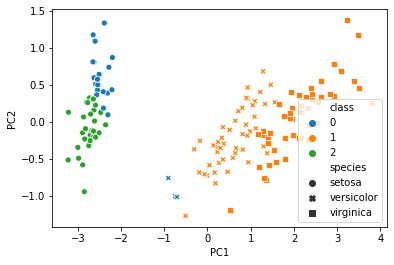

In [46]:
# illustration of bad intial points
bad = df.loc[df.groupby(["init", "n_clusters"])["inertia"].idxmax()]
bad_seed = bad.loc[(bad.init == "random") & (bad.n_clusters == 3)].seed.iloc[0]
cls = KMeans(n_clusters=3, n_init=1, random_state=bad_seed, init="random").fit(iris0)
print(f'inertia: {cls.inertia_}')
scatterplot_pca(data=iris0, hue=cls.labels_, style=iris.species)
plt.show()

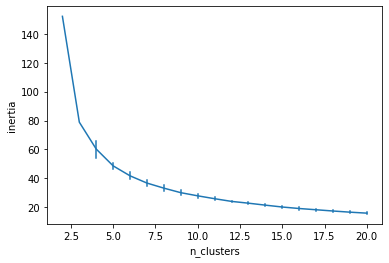

In [52]:
gen = kmeans_dataset(iris0, range(2, 21), ["k-means++"], 20)
df = pd.DataFrame(gen, columns=["seed", "init", "n_clusters","inertia"])
sns.lineplot(
    x="n_clusters",
    y="inertia",
    data=df.loc[df.init == "k-means++"],
    err_style="bars",
    ci="sd",
)
plt.show()

D’après la règle du coude un bon nombre de groupements est 3 voire 4.

## Données Crabs

Effectuer plusieurs classifications en K = 2 classes des données pré-traitées de manière à sup-
primer l’effet taille.

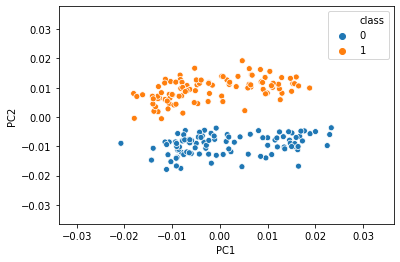

In [63]:
crabs = pd.read_csv("data/crabs.csv", sep="\s+")
crabsquant = crabs.iloc[:, 3:8]
crabsquant = crabsquant.apply(lambda row: row / sum(row), axis=1)

cls = KMeans(n_clusters=2).fit(crabsquant)
scatterplot_pca(data=crabsquant, hue=cls.labels_)
plt.show()

In [ ]:
inertias = [KMeans(n_clusters=2, init="random", n_init=1, random_state=i).fit(crabsquant).inertia_ for i in range(1000)]

In [84]:
len(inertias)

1000

In [75]:
a = [1, 1, 2, 2,3, 2, 3, 3]

In [77]:
insertias, idx_uniq, idx = np.unique(inertias, return_index=True, return_inverse=True)

In [78]:
np.bincount(idx)

array([444, 556])

In [82]:
insertias

array([0.0276453 , 0.02826445])

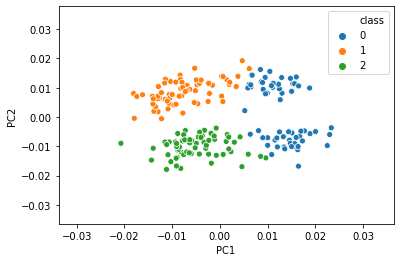

In [85]:
cls = KMeans(n_clusters=3).fit(crabsquant)
scatterplot_pca(data=crabsquant, hue=cls.labels_)
plt.show()

In [90]:
inertias = [KMeans(n_clusters=3, init="random", n_init=1, random_state=i).fit(crabsquant).inertia_ for i in range(1000)]
insertias, idx_uniq, idx = np.unique(inertias, return_index=True, return_inverse=True)
np.bincount(idx)
inertias

array([205,  45,  20,   2,   5, 119,   9,   3,   9,   3,   5,   8,   3,
         1,   2,   9,  12,   7,  95,  20,  23,   5,   9,   4,  49,  11,
       168,   1,  24,   4, 113,   6,   1])

In [121]:
cls = KMeans(n_clusters=4).fit(crabsquant)
adjusted_rand_score(crabs.sp+crabs.sex, cls.labels_) #聚类， 两组数的相似性，判断分类是否准确

0.7512388410567427

In [131]:
adjusted_rand_score([1,1,0,0],[0,0,4,4])

1.0

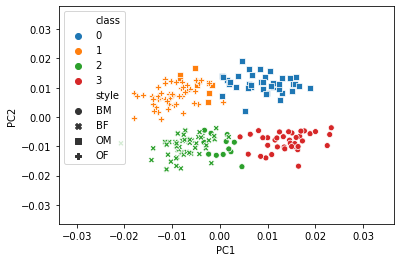

In [129]:
scatterplot_pca(data=crabsquant, hue=cls.labels_, style=crabs.sp+crabs.sex)
plt.show()

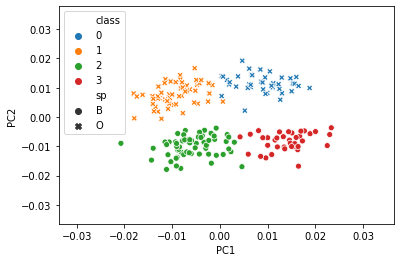

In [132]:
scatterplot_pca(data=crabsquant, hue=cls.labels_, style=crabs.sp)
plt.show()

## 3, De l’intérêt d’une bonne initialisation

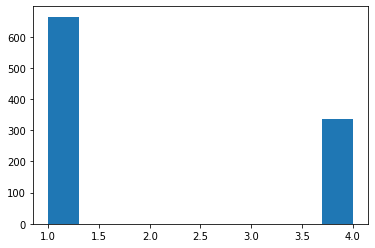

In [154]:
a = 2
b = 1
X = np.array([[a / 2, b / 2], [a / 2, -b / 2], [-a / 2, b / 2], [-a /2, -b / 2]])
inertias = [KMeans(n_clusters=2, n_init=1, random_state=i, init="random").fit(X).inertia_
for i in range(1000)]
plt.hist(inertias)
plt.show()

In [151]:
_, counts = np.unique(inertias, return_counts=True)
counts

array([664, 336])

In [148]:
a = KMeans(n_clusters=2, n_init=202, random_state=1, init="random").fit(X)

In [149]:
a.cluster_centers_

array([[ 0.55,  0.  ],
       [-0.55,  0.  ]])

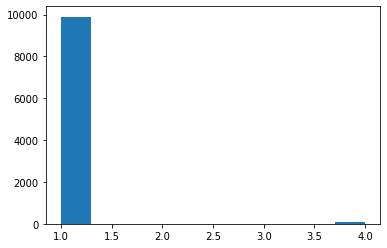

In [157]:
tries = 10000
inertias = [KMeans(n_clusters=2, n_init=1, random_state=i, init="k-means++").fit(X).inertia_ for i in range(tries)]
plt.hist(inertias)
plt.show()

In [159]:
_, counts = np.unique(inertias, return_counts=True)
print(min(counts)/tries)
print(1 / (4 * (1 + (a / b) ** 2) ** 2))

0.0104
0.01


## 4, K-kmeans adaptatif

In [180]:
import numpy.linalg as linalg
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array

0.9799995050507551

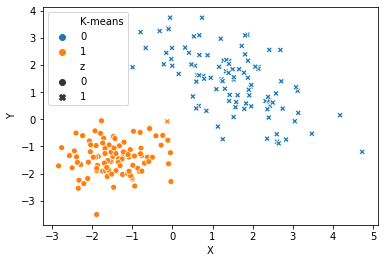

In [191]:
X1 = pd.read_csv("data/Synth1.csv")
z1 = X1.z
X1 = X1.drop(columns=["z"])
cls = KMeans(n_clusters=2)
labels = cls.fit_predict(X1)
s1 = adjusted_rand_score(z1, labels)
labels = pd.Series(labels, name="K-means")
plot_clustering(X1, clus1=labels, clus2=z1)
s1

In [181]:
class AdaptiveKMeans(ClusterMixin, BaseEstimator):
    def __init__(self, n_clusters=8, n_init=10, tol=1e-4, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, X):
        X = check_array(X)

        n, p = X.shape
        n_init = self.n_init
        n_clusters = self.n_clusters
        max_iter = self.max_iter
        tol = self.tol

        centers_opt = None
        Vt_opt = None
        partition_opt = None
        d_opt = float("inf")

        for i in range(n_init):
            # Initialisation des centres des classes avec
            # `np.random.choice`
            centers = np.random.choice(n, size=n_clusters, replace=False)
            centers = X[centers, :]

            # Initialisation des matrices de variance--covariance
            # brutes et normalisées
            Vt = [np.eye(p) for i in range(n_clusters)]
            Vt_norm = [np.eye(p) for i in range(n_clusters)]

            step = tol + 1
            it = 0

            while step > tol and it < max_iter:
                old_centers = centers

                # Calcul d'une nouvelle partition
                dist = np.concatenate(
                    [
                        cdist(c[None, :], X, metric="mahalanobis", VI=linalg.inv(V))
                        for c, V in zip(centers, Vt_norm)
                    ]
                )
                partition = np.argmin(dist, axis=0)

                # Mise à jour des paramètres
                for k in range(n_clusters):
                    # Extraction des individus de class k
                    Xk = X[partition == k, :]

                    # On évite les groupements dégénérés (trop peu de
                    # points pour inverser la matrice de
                    # variance--covariance empirique)
                    if Xk.shape[0] >= p:
                        # Calcul du k-ième centre
                        centers[k, :] = np.mean(Xk, axis=0)

                        # Calcul de la k-ième matrice de
                        # variance-covariance normalisée avec `np.cov` et
                        # `linalg.det`
                        c = np.cov(Xk, bias=True, rowvar=False)
                        c += 1e-5 * np.eye(c.shape[0])

                        Vt[k] = c
                        Vt_norm[k] = (linalg.det(c)) ** (-1 / p) * c

                step = ((old_centers - centers) ** 2).sum()
                it += 1

            # Calcul de `d_tot`. On pourra s'inspirer des instructions
            # permettant de calculer `dist` (voir plus haut).
            d_tot = sum(
                (
                    cdist(
                        c[None, :],
                        X[partition == k, :],
                        metric="mahalanobis",
                        VI=linalg.inv(V),
                    )
                    ** 2
                ).sum()
                for k, (c, V) in enumerate(zip(centers, Vt_norm))
            )

            # Mise à jour du modèle optimal si besoin
            if d_tot < d_opt:
                centers_opt = centers
                Vt_opt = Vt
                Vt_norm_opt = Vt_norm
                partition_opt = partition
                d_opt = d_tot

        self.labels_ = partition_opt
        self.cluster_centers_ = centers_opt
        self.covars_ = Vt_opt
        self.covars_norm_ = Vt_norm_opt
        self.d_opt = d_opt

0.9799995050507551

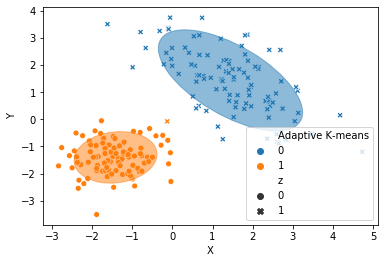

In [192]:
cls = AdaptiveKMeans(n_clusters=2)
labels = cls.fit_predict(X1.to_numpy())
s1a = adjusted_rand_score(z1, labels)
labels = pd.Series(labels, name="Adaptive K-means")
plot_clustering(X1, clus1=labels, clus2=z1, centers=cls.cluster_centers_, covars=cls.covars_)
s1a

In [211]:
X2 = pd.read_csv("data/Synth2.csv")
z2 = X2.z
X2 = X2.drop(columns=["z"])
cls = KMeans(n_clusters=2)
labels = cls.fit_predict(X2)
s2 = adjusted_rand_score(z2, labels)
s2

0.8456245542938297

0.8456245542938297

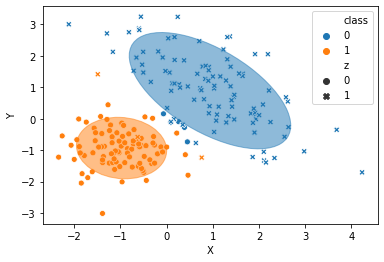

In [217]:
cls = AdaptiveKMeans(n_clusters=2)
labels = cls.fit_predict(X2.to_numpy())
s2a = adjusted_rand_score(z2, labels)
plot_clustering(X2, labels, z2, centers=cls.cluster_centers_, covars=cls.covars_)
s2a

In [218]:
X3 = pd.read_csv("data/Synth3.csv")
z3 = X3.z
X3 = X3.drop(columns=["z"])
cls = KMeans(n_clusters=2)
labels = cls.fit_predict(X3.to_numpy())
s3 = adjusted_rand_score(z3, labels)
s3

0.1328601742085868

0.35678846744347653

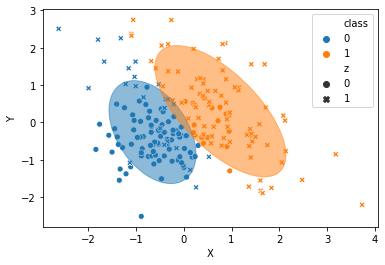

In [219]:
cls = AdaptiveKMeans(n_clusters=2)
labels = cls.fit_predict(X3.to_numpy())
s3a = adjusted_rand_score(z3, labels)
plot_clustering(X3, labels, z3, centers=cls.cluster_centers_, covars=cls.covars_)
s3a

# Classification pixellaire

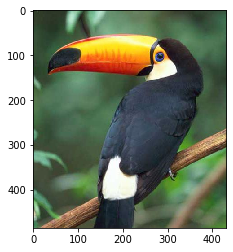

In [221]:
img_toucan = plt.imread("data/toucan.png")
plt.imshow(img_toucan)
plt.show()

In [223]:
img_toucan.shape

(486, 432, 3)

In [226]:
mat_toucan = img_toucan.reshape((-1, 3))

In [227]:
mat_toucan.shape

(209952, 3)

In [228]:
km = KMeans(n_clusters=3)
km.fit(mat_toucan)
img_quant = km.cluster_centers_[km.labels_, :].reshape(img_toucan.shape)
plt.imshow(img_quant)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

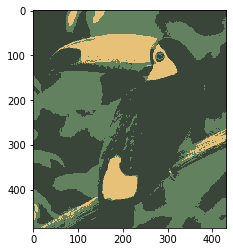

In [234]:
kma = AdaptiveKMeans(n_clusters=3)
kma.fit(mat_toucan)
img_quanta = kma.cluster_centers_[km.labels_, :].reshape(img_toucan.shape)
plt.imshow(img_quanta)

In [238]:
idxs = np.random.choice(range(mat_toucan.shape[0]), size=10000, replace=False)
mat_toucan_sub = pd.DataFrame(mat_toucan[idxs, :])

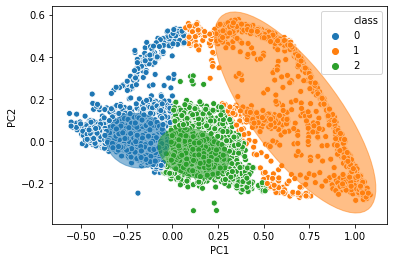

In [239]:
plot_clustering(mat_toucan_sub, kma.labels_[idxs], centers=kma.cluster_centers_, covars=kma.covars_)
plt.show()